In [1]:
import pickle
import numpy as np
import torch
import sys
import pandas as pd

sys.path.insert(0, '/research/iprobe-ashbau12/repos/outside/OpenGait/opengait/')
from utils.evaluation import cuda_dist
from tools.briar_parser import BRIARDataset

BTS1_location = '/research/iprobe/datastore/datasets/briar/ORNL/BTS1'
BTS1_df = '/research/iprobe-ashbau12/repos/briar-parser/briar_BTS1_dataset_full_distractor.pkl'

import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline
dpi = 150

In [2]:
BTS1 = BRIARDataset(BTS1_location, BTS1_df)

In [3]:
test_metric_file = "./accuracy_and_seqs_random_500_s2s.pkl"

with open(test_metric_file, "rb") as f:
    false_in_row_until_correct_match = pickle.load(f)
    acc = pickle.load(f)
    probe_seqs = pickle.load(f)
    gallery_seqs = pickle.load(f)                               
    seq_type = pickle.load(f)
    gallery_y = pickle.load(f)
    label = pickle.load(f)
    probe_sequence_label_mask = pickle.load(f)
    gallery_labels = pickle.load(f)
    to_save = pickle.load(f)
    all_video_fnames = pickle.load(f)

In [4]:
probe_seq_mask = np.isin(seq_type, probe_seqs) & probe_sequence_label_mask
print(np.where(probe_seq_mask)[0])

[   96    97    98 ... 26395 26396 26397]


In [5]:
false_in_row_until_correct_match.shape

(16938, 11)

In [6]:
fnames_for_probes_sequences = np.asarray(all_video_fnames)[np.where(probe_seq_mask)]
print(fnames_for_probes_sequences)

['G00380_set1_rand_1622569450579_31fc247a'
 'G00380_set1_rand_1622569450579_31fc247a'
 'G00380_set1_rand_1622569450597_707b2f7f' ...
 'G00354_set2_struct_Q6215-LE_ACCC8EEAB537_8d6dd934'
 'G00354_set2_struct_Q6215-LE_ACCC8EEAB537_8d6dd934'
 'G00354_set2_struct_Q6215-LE_ACCC8EEAB537_8d6dd934']


In [7]:
# all videos belonging to a subject which has gallery
probe_sequence_label_mask.sum()

23159

In [8]:
BTS1.full_label_df.columns

Index(['path', 'fname', 'controlled/field', 'stand/struct/rand', 'wb/face',
       'set_num', 'subject_id', 'full/distractor', 'distance/uav',
       'labels_path', 'wb_labels', 'face_labels'],
      dtype='object')

In [9]:
index_of_video = np.where(BTS1.full_label_df['fname'] == 
                          fnames_for_probes_sequences[0])[0][0]
BTS1.full_label_df['distance/uav'][index_of_video]

'200m'

In [10]:
distance_rank_results_df = pd.DataFrame()
distance_rank_results_df['fname'] = fnames_for_probes_sequences

# BTS1.full_label_df[['fname', 'distance/uav']]
distances = []
conditions = []
for ii, name in enumerate(distance_rank_results_df['fname']):
    index_of_video = np.where(BTS1.full_label_df['fname'] == 
                              name)[0][0]
    distances.append(BTS1.full_label_df['distance/uav'][index_of_video])
    conditions.append(BTS1.full_label_df['stand/struct/rand'][index_of_video])
    
distance_rank_results_df['distance/uav'] = distances
distance_rank_results_df['stand/struct/rand'] = conditions
distance_rank_results_df['rank-1'] = false_in_row_until_correct_match[:, 0]
distance_rank_results_df['rank-5'] = false_in_row_until_correct_match[:, 4]
distance_rank_results_df['rank-10'] = false_in_row_until_correct_match[:, 9]

In [11]:
distance_rank_results_df.loc[0]

fname                G00380_set1_rand_1622569450579_31fc247a
distance/uav                                            200m
stand/struct/rand                                       rand
rank-1                                                  True
rank-5                                                  True
rank-10                                                 True
Name: 0, dtype: object

In [12]:
distance_rank_results_df

,fname,distance/uav,stand/struct/rand,rank-1,rank-5,rank-10
0,G00380_set1_rand_1622569450579_31fc247a,200m,rand,True,True,True
1,G00380_set1_rand_1622569450579_31fc247a,200m,rand,True,True,True
2,G00380_set1_rand_1622569450597_707b2f7f,500m,rand,False,True,True
3,G00380_set1_rand_1622569450597_707b2f7f,500m,rand,False,True,True
4,G00380_set1_rand_1622569450597_707b2f7f,500m,rand,False,True,True
...,...,...,...,...,...,...
16933,G00354_set2_struct_DWC-MPTZ336XW_0007D81E134C_...,100m,struct,True,True,True
16934,G00354_set2_struct_Q6215-LE_ACCC8EEAB537_8d6dd934,close_range,struct,True,True,True
16935,G00354_set2_struct_Q6215-LE_ACCC8EEAB537_8d6dd934,close_range,struct,True,True,True
16936,G00354_set2_struct_Q6215-LE_ACCC8EEAB537_8d6dd934,close_range,struct,True,True,True


In [13]:
distance_list = list(set(distance_rank_results_df['distance/uav']))
num_distances = len(distance_list)
rank_percentage_distance = {} # np.zeros((num_distances, 3))

condition_list = list(set(distance_rank_results_df['stand/struct/rand']))
num_conditions = len(condition_list)
rank_percentage_condition = {} # np.zeros((num_conditions, 3))

for ii, distance in enumerate(distance_list):
    current_distance_rows = \
        distance_rank_results_df.loc[distance_rank_results_df['distance/uav']
                                     == distance]
    num_matches_in_ranks = current_distance_rows[['rank-1', 'rank-5', 'rank-10']].sum(0)
    portion_of_matches = num_matches_in_ranks / current_distance_rows.shape[0]
    rank_percentage_distance[distance] = portion_of_matches
    
for ii, condition in enumerate(condition_list):
    current_condition_rows = \
        distance_rank_results_df.loc[distance_rank_results_df['stand/struct/rand']
                                     == condition]
    num_matches_in_ranks = current_condition_rows[['rank-1', 'rank-5', 'rank-10']].sum(0)
    portion_of_matches = num_matches_in_ranks / current_condition_rows.shape[0]
    rank_percentage_condition[condition] = portion_of_matches
    
print(rank_percentage_distance)
print(rank_percentage_condition)


{'close_range': rank-1     0.989090
rank-5     0.999171
rank-10    0.999171
dtype: float64, '500m': rank-1     0.815829
rank-5     0.941762
rank-10    0.967148
dtype: float64, '400m': rank-1     0.795403
rank-5     0.906556
rank-10    0.946496
dtype: float64, '100m': rank-1     0.983429
rank-5     1.000000
rank-10    1.000000
dtype: float64, '200m': rank-1     0.823668
rank-5     0.953136
rank-10    0.978422
dtype: float64, 'uav': rank-1     0.864780
rank-5     0.959119
rank-10    0.981132
dtype: float64}
{'rand': rank-1     0.916023
rank-5     0.976816
rank-10    0.988150
dtype: float64, 'stand': rank-1     0.874588
rank-5     0.955269
rank-10    0.974204
dtype: float64, 'struct': rank-1     0.939840
rank-5     0.981449
rank-10    0.991331
dtype: float64}


<Figure size 432x288 with 0 Axes>

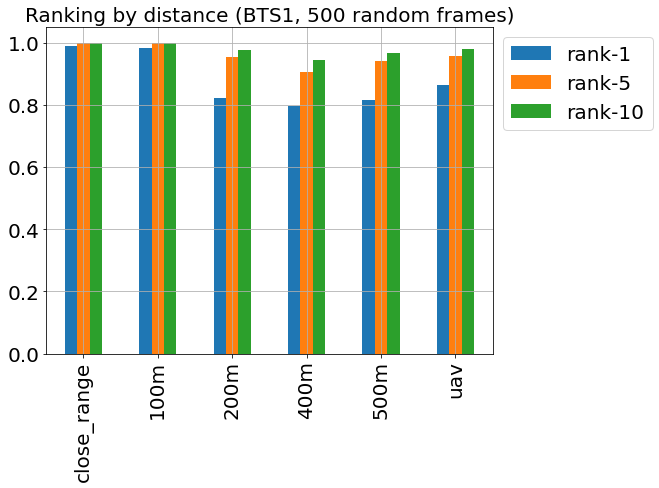

         close_range      100m      200m      400m      500m       uav
rank-1      0.989090  0.983429  0.823668  0.795403  0.815829  0.864780
rank-5      0.999171  1.000000  0.953136  0.906556  0.941762  0.959119
rank-10     0.999171  1.000000  0.978422  0.946496  0.967148  0.981132


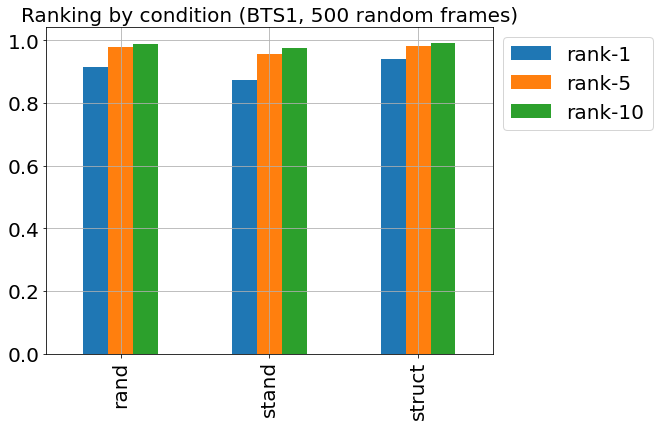

             rand     stand    struct
rank-1   0.916023  0.874588  0.939840
rank-5   0.976816  0.955269  0.981449
rank-10  0.988150  0.974204  0.991331


In [21]:
fontsize = 20
figsize = (8,6)

distance_plot_df = pd.DataFrame(rank_percentage_distance).transpose()
distance_plot_df = distance_plot_df.reindex(['close_range',
                                             '100m',
                                             '200m',
                                             '400m',
                                             '500m',
                                             'uav'])
fig = plt.figure(facecolor='white')
axes = distance_plot_df.plot(kind='bar',
                             grid=True,
                             legend=False,
                             figsize=figsize,
                             fontsize=fontsize
                            )
axes.set_facecolor('white')
axes.legend(bbox_to_anchor=(1, 1),
            loc='upper left',
            fontsize=fontsize
           )
plt.title('Ranking by distance (BTS1, 500 random frames)',
           fontsize=fontsize
         )
plt.show()
print(distance_plot_df.transpose())


condition_plot_df = pd.DataFrame(rank_percentage_condition).transpose()
axes = condition_plot_df.plot(kind='bar',
                              grid=True,
                              legend=False,
                              figsize=figsize,
                              fontsize=fontsize
                             )
axes.legend(bbox_to_anchor=(1, 1),
            loc='upper left',
            fontsize=fontsize
           )
plt.title('Ranking by condition (BTS1, 500 random frames)',
          fontsize=fontsize
         )
plt.show()
print(condition_plot_df.transpose())


In [15]:
distance_plot_df.transpose()

,close_range,100m,200m,400m,500m,uav
rank-1,0.989090,0.983429,0.823668,0.795403,0.815829,0.864780
rank-5,0.999171,1.000000,0.953136,0.906556,0.941762,0.959119
rank-10,0.999171,1.000000,0.978422,0.946496,0.967148,0.981132


In [16]:
distance_plot_df.sort_index()

,rank-1,rank-5,rank-10
100m,0.983429,1.000000,1.000000
200m,0.823668,0.953136,0.978422
400m,0.795403,0.906556,0.946496
500m,0.815829,0.941762,0.967148
close_range,0.989090,0.999171,0.999171
uav,0.864780,0.959119,0.981132


In [17]:
distance_list

['close_range', '500m', '400m', '100m', '200m', 'uav']

TypeError: bar() missing 1 required positional argument: 'height'

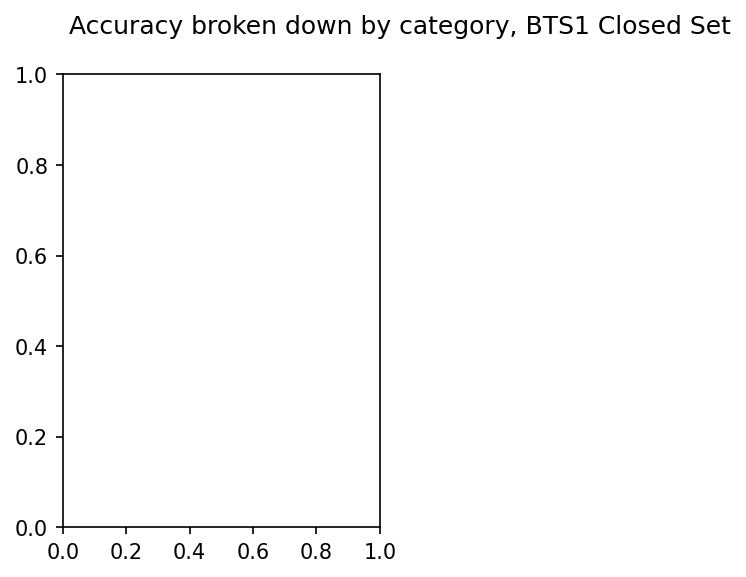

In [18]:
fig2 = plt.figure(facecolor='white', dpi=dpi)
fig2.suptitle('Accuracy broken down by category, BTS1 Closed Set')

plt.subplot(1, 2, 1)
X = np.arange(4)
plt.bar(distance_plot_df, )

In [ ]:
false_in_row_until_correct_match

In [ ]:
def isProbeInTopN(probe_y, gallery_y, sorted_indices, rank):
    '''
    columns are N ranks
    rows are probes
    '''
    probe_in_top_N = np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[sorted_indices[:, 0:rank]], 1) > 0
    return probe_in_top_N


def findCorrectMatches(probe_in_top_N):
    correct_matches = probe_in_top_N.cumsum(axis=1) == 1
    return correct_matches


def isCorrectMatchWithinRankN(correct_matches, rank):
    # be sure to pass only mated probes, since if a row that is all false will
    # have argmax return 0
    probe_match_within_rank_N = correct_matches.argmax(axis=1) < rank
    return probe_match_within_rank_N

In [ ]:
correct_matches = findCorrectMatches(false_in_row_until_correct_match)
rank_5_sequences = isCorrectMatchWithinRankN(correct_matches, 9)
rank_6_sequences = isCorrectMatchWithinRankN(correct_matches, 10)

In [ ]:
len(np.where(rank_5_sequences)[0])

In [ ]:
a = set(np.where((rank_5_sequences == False) & (rank_6_sequences == True))[0])

In [ ]:
len(a)